In [1]:
import requests
import pandas as pd
import time
from io import StringIO
import random
import os

In [2]:
player_ids = [
    "j/jamesle01", "c/curryst01", "d/duranke01", "a/antetgi01", "d/doncilu01",
    "j/jokicni01", "e/embiijo01", "t/tatumja01", "b/butleji01", "l/leonaka01",
    "l/lillada01", "h/hardeja01", "d/davisan02", "b/bookede01", "m/mitchdo01",
    "w/willizi01", "m/moranja01", "y/youngtr01", "t/townska01", "b/bealbr01",
    "g/georgpa01", "i/irvinky01", "p/paulch01", "d/derozde01", "w/westbru01",
    "a/adebaba01", "h/holidjr01", "m/middlkh01", "s/siakapa01", "v/vanvlfr01",
    "g/gilgesh01", "i/ingrabr01", "m/mccolcj01", "b/ballla01", "h/halibty01",
    "r/randlju01", "b/barrerj01", "f/foxde01", "s/sabondo01", "t/turnemy01",
    "p/portemi01", "m/murraja01", "w/wiggian01", "g/greenra01", "v/vucicni01",
    "m/mobleev01", "s/smithja02", "b/barnesc01", "b/banchpa01", "s/suggsca01"
]



In [2]:


def scrape_player_game_logs(player_id, season="2025"):
    """
    Scrapes a player's NBA season game logs from Basketball Reference.
    
    Args:
        player_id (str): Player ID from Basketball Reference (e.g., 'jamesle01' or 'j/jamesle01')
        season (str): Season year (e.g., '2024' for 2023-2024 season)
    """
    # Check if player_id already contains the first letter path
    if '/' in player_id:
        # Player ID already includes the letter path (e.g., 'j/jamesle01')
        url = f"https://www.basketball-reference.com/players/{player_id}/gamelog/{season}"
    else:
        # Player ID is just the ID part (e.g., 'jamesle01')
        url = f"https://www.basketball-reference.com/players/{player_id[0]}/{player_id}/gamelog/{season}"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    print(f"Sending request to Basketball Reference for player {player_id}...")
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            print(f"Request successful! Status code: {response.status_code}")
            html_io = StringIO(response.text)
            print("Parsing tables with pandas...")
            try:
                tables = pd.read_html(html_io, attrs={'id': 'pgl_basic'})
                if tables and len(tables) > 0:
                    print("Found game log table by ID!")
                    game_log_df = tables[0]
                    processed_df = process_dataframe(game_log_df)
                    processed_df['player_id'] = player_id  # Add player_id column
                    return processed_df
            except Exception as e:
                print(f"Couldn't find table by ID: {e}")
                html_io.seek(0)
                tables = pd.read_html(html_io)
                tables_sorted = sorted(tables, key=lambda x: len(x), reverse=True)
                if tables_sorted:
                    game_log_df = tables_sorted[0]
                    print(f"Table found! Dimensions: {game_log_df.shape}")
                    processed_df = process_dataframe(game_log_df)
                    processed_df['player_id'] = player_id  # Add player_id column
                    return processed_df
                else:
                    print("No tables found on the page.")
                    return None
        else:
            print(f"Request failed with status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error during scraping: {e}")
        return None

def process_dataframe(game_log_df):
    """
    Process the raw dataframe from Basketball Reference to clean and format it properly.
    """
    print("Processing the game log dataframe...")
    # Print the first few rows to help with debugging
    print("First few rows of raw data:")
    print(game_log_df.head(3))
    
    if isinstance(game_log_df.columns, pd.MultiIndex):
        # Handle multi-level columns
        game_log_df.columns = [' '.join(str(col) for col in cols if str(col) != 'Unnamed: 0_level_0').strip() 
                             for cols in game_log_df.columns.values]
    
    print("Raw columns:", game_log_df.columns.tolist())
    
    # Remove header rows (where Rk column appears again in the data)
    game_log_df = game_log_df[~game_log_df.iloc[:, 0].astype(str).str.contains("Rk")]
    
    # Remove unnamed columns
    unnamed_cols = [col for col in game_log_df.columns if 'Unnamed' in str(col)]
    if unnamed_cols:
        game_log_df = game_log_df.drop(columns=unnamed_cols)
    
    # Handle team column naming
    if 'Tm' in game_log_df.columns and 'Team' not in game_log_df.columns:
        game_log_df = game_log_df.rename(columns={'Tm': 'Team'})
    elif 'Tm' in game_log_df.columns and 'Team' in game_log_df.columns and game_log_df['Team'].isna().all():
        game_log_df['Team'] = game_log_df['Tm']
        game_log_df = game_log_df.drop(columns=['Tm'])
    
    # Fill missing team values
    if 'Team' in game_log_df.columns and game_log_df['Team'].isna().any():
        game_log_df['Team'] = game_log_df['Team'].fillna('Unknown')
    elif 'Team' not in game_log_df.columns and 'Tm' not in game_log_df.columns:
        game_log_df['Team'] = 'Unknown'
    
    # Check for and handle the MP (Minutes Played) column
    if 'MP' in game_log_df.columns:
        
        game_log_df['MP'] = game_log_df['MP'].apply(lambda x: convert_minutes_format(x) if pd.notna(x) else x)
    elif 'MIN' in game_log_df.columns:
        game_log_df = game_log_df.rename(columns={'MIN': 'MP'})
        game_log_df['MP'] = game_log_df['MP'].apply(lambda x: convert_minutes_format(x) if pd.notna(x) else x)
    
    # Convert all possible numeric columns
    for col in game_log_df.columns:
        if col not in ['Date', 'Tm', 'Team', 'Opp', 'Result', 'GS', 'player_id']:
            game_log_df[col] = pd.to_numeric(game_log_df[col], errors='coerce')
    
    # Additional check for MP column
    if 'MP' not in game_log_df.columns:
        print("MP column not found in the data. Available columns:", game_log_df.columns.tolist())
        game_log_df['MP'] = None  # Create the column with None values if it doesn't exist
        
        
        minute_column_variants = ['Minutes', 'Min', 'Mins', 'Minutes Played']
        for col_name in minute_column_variants:
            if col_name in game_log_df.columns:
                game_log_df['MP'] = game_log_df[col_name]
                game_log_df['MP'] = game_log_df['MP'].apply(lambda x: convert_minutes_format(x) if pd.notna(x) else x)
                print(f"Found minutes data in column: {col_name}")
                break
    
    expected_columns = ['Date', 'Team', 'Opp', 'Result', 'MP']
    missing_cols = [col for col in expected_columns if col not in game_log_df.columns]
    if missing_cols:
        print(f"Warning: Missing expected columns: {missing_cols}")
    
    return game_log_df

def convert_minutes_format(minutes_str):
    """
    Convert minutes from 'MM:SS' string format to decimal minutes.
    Example: '36:12' becomes 36.2 (36 minutes and 12 seconds)
    """
    try:
        if isinstance(minutes_str, (int, float)):
            return float(minutes_str)
        elif isinstance(minutes_str, str):
            if ':' in minutes_str:
                parts = minutes_str.split(':')
                if len(parts) == 2:
                    minutes = int(parts[0])
                    seconds = int(parts[1])
                    return minutes + seconds/60
            else:
                return float(minutes_str)
        return None
    except Exception as e:
        print(f"Error converting minutes format: {e}, value was: {minutes_str}")
        return None

def save_to_csv(df, filename='nba_player_game_logs.csv'):
    """
    Saves the DataFrame to a CSV file.
    """
    if df is not None:
        try:
            df.to_csv(filename, index=False)
            print(f"Data saved to {filename}")
            return True
        except Exception as e:
            print(f"Error saving CSV: {e}")
            return False
    else:
        print("No data to save.")
        return False

def main():
    """
    Main function to execute the scraping workflow for multiple players.
    """
    # List of player IDs to scrape
    player_ids = [
        "j/jamesle01", "c/curryst01", "d/duranke01", "a/antetgi01", "d/doncilu01", 
        "j/jokicni01", "e/embiijo01", "t/tatumja01", "b/butleji01", "l/leonaka01", 
        "l/lillada01", "h/hardeja01", "d/davisan02", "b/bookede01", "m/mitchdo01", 
        "w/willizi01", "m/moranja01", "y/youngtr01", "t/townska01", "b/bealbr01", 
        "g/georgpa01", "i/irvinky01", "p/paulch01", "d/derozde01", "w/westbru01", 
        "a/adebaba01", "h/holidjr01", "m/middlkh01", "s/siakapa01", "v/vanvlfr01", 
        "g/gilgesh01", "i/ingrabr01", "m/mccolcj01", "b/ballla01", "h/halibty01", 
        "r/randlju01", "b/barrerj01", "f/foxde01", "s/sabondo01", "t/turnemy01", 
        "p/portemi01", "m/murraja01", "w/wiggian01", "g/greenra01", "v/vucicni01", 
        "m/mobleev01", "s/smithja02", "b/barnesc01", "b/banchpa01", "s/suggsca01"
    ]
    
    season = "2025"  
    
    print(f"Starting NBA game log scraper for {len(player_ids)} players...")
    start_time = time.time()
    
    all_game_logs = []
    
    
    checkpoint_interval = 5  # Save after every 5 players
    
    for i, player_id in enumerate(player_ids):
        print(f"\nScraping data for player {i+1}/{len(player_ids)}: {player_id}")
        player_game_logs = scrape_player_game_logs(player_id, season)
        
        if player_game_logs is not None:
            all_game_logs.append(player_game_logs)
            print(f"Successfully scraped {len(player_game_logs)} games for {player_id}")
            
            # Save checkpoint after every few players
            if (i + 1) % checkpoint_interval == 0 and all_game_logs:
                checkpoint_df = pd.concat(all_game_logs, ignore_index=True)
                checkpoint_filename = f"checkpoint_nba_logs_{i+1}_players.csv"
                save_to_csv(checkpoint_df, checkpoint_filename)
                print(f"Checkpoint saved to {checkpoint_filename} after {i+1} players")
            
            # Add a significant delay between players to avoid rate limiting
            if i < len(player_ids) - 1:  
                wait_time = 10 + random.randint(5, 15)  
                

        else:
            print(f"Failed to scrape data for {player_id}")
            
            if i < len(player_ids) - 1:
                wait_time = 15 + random.randint(5, 15)
               

    
    # Combine all player data into a single DataFrame
    if all_game_logs:
        combined_df = pd.concat(all_game_logs, ignore_index=True)
        print(f"\nCombined dataset created with {len(combined_df)} total game logs")
        
        # Save combined data
        save_to_csv(combined_df, f"nba_game_logs_{season}.csv")
        
        # Print sample and statistics
        print("\nSample of the scraped data:")
        print(combined_df.head())
        
        print("\nBasic statistics:")
        print(f"Total games: {len(combined_df)}")
        print(f"Players included: {combined_df['player_id'].nunique()}")
        print("\nAvailable columns:")
        print(combined_df.columns.tolist())
        
        # Save intermediate results after every 10 players
        print("\nTotal time elapsed:", time.time() - start_time)
    else:
        print("Scraping failed for all players.")


In [3]:


def load_existing_data(filename='nba_game_logs_2025.csv'):
    """
    Load existing dataset if available, return empty DataFrame if file doesn't exist.
    """
    try:
        if os.path.exists(filename):
            df = pd.read_csv(filename)
            print(f"Loaded existing dataset with {len(df)} records from {filename}")
            return df
        else:
            print(f"File {filename} not found. Will create a new dataset.")
            return None
    except Exception as e:
        print(f"Error loading existing data: {e}")
        return None

def scrape_additional_players(new_player_ids, existing_filename='nba_game_logs_2025.csv', season="2025"):
    """
    Scrapes game logs for new players and combines with existing data.
    """
    # Load existing data
    existing_df = load_existing_data(existing_filename)
    
    # Get list of players already in the dataset to avoid duplicates
    existing_players = set()
    if existing_df is not None and 'player_id' in existing_df.columns:
        existing_players = set(existing_df['player_id'].unique())
        print(f"Existing dataset contains {len(existing_players)} players")
    
    # Filter out players that are already in the dataset
    players_to_scrape = [p_id for p_id in new_player_ids if p_id not in existing_players]
    
    if not players_to_scrape:
        print("All players in the new list are already in the dataset. Nothing to scrape.")
        return existing_df
    
    print(f"Scraping data for {len(players_to_scrape)} new players...")
    
    # Scrape the new players
    start_time = time.time()
    new_game_logs = []
    checkpoint_interval = 5
    
    for i, player_id in enumerate(players_to_scrape):
        print(f"\nScraping data for new player {i+1}/{len(players_to_scrape)}: {player_id}")
        player_game_logs = scrape_player_game_logs(player_id, season)
        
        if player_game_logs is not None:
            new_game_logs.append(player_game_logs)
            print(f"Successfully scraped {len(player_game_logs)} games for {player_id}")
            
            # Save checkpoint after every few players
            if (i + 1) % checkpoint_interval == 0 and new_game_logs:
                checkpoint_df = pd.concat(new_game_logs, ignore_index=True)
                checkpoint_filename = f"new_checkpoint_nba_logs_{i+1}_players.csv"
                save_to_csv(checkpoint_df, checkpoint_filename)
                print(f"Checkpoint saved to {checkpoint_filename} after {i+1} new players")
            
            # No waiting time between players
            print("Continuing to next player immediately...")
        else:
            print(f"Failed to scrape data for {player_id}")
            
            if i < len(players_to_scrape) - 1:
                print("Continuing to next player...")
    
    # Combine all new player data
    if new_game_logs:
        new_combined_df = pd.concat(new_game_logs, ignore_index=True)
        print(f"\nNew dataset created with {len(new_combined_df)} total game logs")
        
        # Merge with existing data if it exists
        if existing_df is not None:
            # Combine new data with existing data
            final_df = pd.concat([existing_df, new_combined_df], ignore_index=True)
            print(f"Combined dataset now has {len(final_df)} total game logs from {final_df['player_id'].nunique()} players")
        else:
            final_df = new_combined_df
            print(f"No existing data to merge. New dataset has {len(final_df)} game logs")
        
        # Save combined data
        save_to_csv(final_df, existing_filename)
        
        # Print sample and statistics
        print("\nSample of the updated dataset:")
        print(final_df.head())
        
        print("\nBasic statistics:")
        print(f"Total games: {len(final_df)}")
        print(f"Players included: {final_df['player_id'].nunique()}")
        print("Total scraping time:", time.time() - start_time)
        
        return final_df
    else:
        print("Scraping failed for all new players.")
        return existing_df

def main_additional():
    """
    Main function to add new players to the existing dataset.
    """
    # Specify the new list of player IDs to scrape
    new_player_ids = [
        # Add your new list of player IDs here
        "e/edwaran01", "g/giddesh01", "h/hendeco01", "m/maxeyty01", "m/murraja01", 
        "h/holmgri01", "b/brogdma01", "a/aytonde01", "j/johnsja05", "r/reeveau01",
        "b/brownja02", "b/banchpa01", "w/wagnefr01", "s/sengaal01", "t/thomptr01",
        "p/porzikr01", "m/murrays01", "b/brunjan01", "h/hartjo01", "a/aldrila01",
        "r/russeda01", "h/hayesjk01", "w/washinpj01", "c/claxcni01", "d/davisan03",
        "g/gainesd01", "m/millspa01", "l/lowryky01", "w/whitede01", "c/claxtca01",
        "g/goberru01", "a/allenja01", "p/poweljn01", "b/brissoo01", "p/poeleja01"
    ]
    
    existing_filename = "nba_game_logs_2025.csv"  # The name of your existing dataset
    season = "2025"
    
    # Run the scraping and data aggregation
    final_dataset = scrape_additional_players(new_player_ids, existing_filename, season)
    
    if final_dataset is not None:
        print("\nData aggregation complete! Updated dataset is saved to", existing_filename)
    else:
        print("\nFailed to update the dataset.")

if __name__ == '__main__':
    # Use main_additional() instead of main() to scrape additional players
    main_additional()


Loaded existing dataset with 2570 records from nba_game_logs_2025.csv
Existing dataset contains 31 players
Scraping data for 35 new players...

Scraping data for new player 1/35: e/edwaran01
Sending request to Basketball Reference for player e/edwaran01...
Request successful! Status code: 200
Parsing tables with pandas...
Couldn't find table by ID: No tables found
Table found! Dimensions: (89, 34)
Processing the game log dataframe...
First few rows of raw data:
  Rk Gcar Gtm        Date Team Unnamed: 5  Opp      Result GS     MP  ... DRB  \
0  1  303   1  2024-10-22  MIN          @  LAL  L, 103-110  *  41:04  ...   6   
1  2  304   2  2024-10-24  MIN          @  SAC  W, 117-115  *  39:12  ...   6   
2  3  305   3  2024-10-26  MIN        NaN  TOR  W, 112-101  *  39:11  ...   6   

  TRB AST STL BLK TOV PF PTS  GmSc +/-  
0   6   3   0   0   4  3  27  11.8   0  
1   7   4   1   0   3  4  32  20.9   8  
2   6   4   1   1   4  3  24  13.2   5  

[3 rows x 34 columns]
Raw columns: ['Rk', 'G

In [6]:
def main_additional():
    """
    Main function to add new players to the existing dataset.
    """
    # Specify the new list of player IDs to scrape
    new_player_ids = [
    "r/risacza01", "s/sarral01", "s/sheppre01", "c/castlst01", "h/hollaro01", "s/salauti01",
    "c/clingdo01", "d/dilliro01", "e/edeyza01", "w/willico01", "b/buzelma01", "t/topicni01",
    "c/carte01", "c/carrica01", "w/wareke01", "m/mccaija01", "k/knechda01", "d/dasiltr01",
    "w/walteja01", "t/tysonja01", "m/missiyv01", "h/holmeda01", "j/johnsaj01", "g/georgky01",
    "d/dadiep01", "j/jonesdi01", "s/shannte01", "d/dunnry01", "c/colliis01", "s/scheiba01",
    "s/smithty01", "j/jamesbr01", "m/mogbojo01", "f/filipky01", "k/klintbo01", "m/mitchaj01",
    "w/wellsja01", "i/ighodos01", "b/bonaad01", "s/simpskj01", "d/djurini01", "l/larrspe01",
    "s/sheadja01", "c/chrisca01", "r/reevean01", "i/ingrah01", "n/newtotr01", "f/freemen01",
    "a/ajincme01", "p/postqu01", "s/spencam01", "w/watsoan01", "c/chomcul01", "h/hukpoar01"
]

    
    existing_filename = "nba_game_logs_2025.csv"  # The name of your existing dataset
    season = "2025"
    
    # Run the scraping and data aggregation
    final_dataset = scrape_additional_players(new_player_ids, existing_filename, season)
    
    if final_dataset is not None:
        print("\nData aggregation complete! Updated dataset is saved to", existing_filename)
    else:
        print("\nFailed to update the dataset.")

if __name__ == '__main__':
    # Use main_additional() instead of main() to scrape additional players
    main_additional()


Loaded existing dataset with 3648 records from nba_game_logs_2025.csv
Existing dataset contains 44 players
Scraping data for 54 new players...

Scraping data for new player 1/54: r/risacza01
Sending request to Basketball Reference for player r/risacza01...
Request failed with status code: 429
Failed to scrape data for r/risacza01
Continuing to next player...

Scraping data for new player 2/54: s/sarral01
Sending request to Basketball Reference for player s/sarral01...
Request failed with status code: 429
Failed to scrape data for s/sarral01
Continuing to next player...

Scraping data for new player 3/54: s/sheppre01
Sending request to Basketball Reference for player s/sheppre01...
Request failed with status code: 429
Failed to scrape data for s/sheppre01
Continuing to next player...

Scraping data for new player 4/54: c/castlst01
Sending request to Basketball Reference for player c/castlst01...
Request failed with status code: 429
Failed to scrape data for c/castlst01
Continuing to nex

In [4]:
df=pd.read_csv("nba_game_logs_2025.csv")
df

,Rk,Gcar,Gtm,Date,Team,Opp,Result,GS,MP,FG,...,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,player_id
0,1.0,1493.0,1.0,2024-10-22,LAL,MIN,"W, 110-103",*,34.650000,7.0,...,5.0,4.0,0.0,2.0,2.0,3.0,16.0,10.1,-6.0,j/jamesle01
1,2.0,1494.0,2.0,2024-10-25,LAL,PHO,"W, 123-116",*,34.700000,7.0,...,4.0,8.0,0.0,0.0,2.0,1.0,21.0,17.9,14.0,j/jamesle01
2,3.0,1495.0,3.0,2024-10-26,LAL,SAC,"W, 131-127",*,33.766667,12.0,...,14.0,10.0,0.0,1.0,5.0,3.0,32.0,27.1,13.0,j/jamesle01
3,4.0,1496.0,4.0,2024-10-28,LAL,PHO,"L, 105-109",*,35.800000,3.0,...,5.0,8.0,1.0,0.0,2.0,1.0,11.0,6.9,-17.0,j/jamesle01
4,5.0,1497.0,5.0,2024-10-30,LAL,CLE,"L, 110-134",*,28.966667,9.0,...,6.0,3.0,0.0,0.0,6.0,2.0,26.0,18.0,-17.0,j/jamesle01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,58.0,NaN,79.0,2025-04-08,BRK,NOP,"W, 119-114",Inactive,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,r/russeda01
3644,58.0,NaN,80.0,2025-04-10,BRK,ATL,"L, 109-133",Inactive,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,r/russeda01
3645,58.0,NaN,81.0,2025-04-11,BRK,MIN,"L, 91-117",Inactive,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,r/russeda01
3646,58.0,NaN,82.0,2025-04-13,BRK,NYK,"L, 105-113",Inactive,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,r/russeda01


In [4]:
import re
import pandas as pd

def decode_player_id(player_id):
    """
    Décode un identifiant Basketball Reference pour obtenir le nom et prénom du joueur.
    
    Format typique: x/xxxxxaa00 où:
    - Première lettre est généralement la première lettre du nom de famille
    - Les cinq premières lettres après le slash sont généralement les 5 premières lettres du nom de famille
    - Les deux lettres suivantes sont généralement les 2 premières lettres du prénom
    - Les deux chiffres à la fin distinguent les joueurs avec les mêmes initiales
    
    Exemples:
    - j/jamesle01 -> LeBron James
    - c/curryst01 -> Stephen Curry
    - d/duranke01 -> Kevin Durant
    """
    # Vérifier le format de l'identifiant
    if not player_id or '/' not in player_id:
        return "Format d'identifiant invalide"
    
    # Extraire la partie après le slash
    parts = player_id.split('/')
    if len(parts) != 2:
        return "Format d'identifiant invalide"
    
    code = parts[1]
    
    # Regex pour extraire les composants: 5 lettres du nom, 2 lettres du prénom, 2 chiffres
    pattern = r"([a-z]{5})([a-z]{2})(\d{2})"
    match = re.match(pattern, code)
    
    if not match:
        return f"Format non reconnu"
    
    lastname_code = match.group(1)
    firstname_code = match.group(2)
    
    # Cette partie est approximative car nous ne pouvons pas connaître les noms exacts sans une base de données
    # On peut proposer une estimation basée sur les conventions de Basketball Reference
    lastname_guess = lastname_code.capitalize()
    firstname_guess = firstname_code.capitalize()
    
    return f"{firstname_guess}... {lastname_guess}... (estimation)"

def process_player_ids_from_csv(file_path):
    """
    Traite un fichier CSV contenant des identifiants de joueurs Basketball Reference.
    Le CSV doit contenir une colonne 'player_id' ou similaire.
    """
    try:
        # Lire le fichier CSV
        df = pd.read_csv(file_path)
        
        # Trouver la colonne qui contient les identifiants des joueurs
        id_column = None
        for col in df.columns:
            if 'id' in col.lower() or 'player' in col.lower():
                id_column = col
                break
        
        if not id_column:
            return "Aucune colonne d'identifiants de joueurs trouvée dans le CSV"
        
        # Appliquer la fonction de décodage à chaque identifiant
        df['player_name_guess'] = df[id_column].apply(decode_player_id)
        
        # Sauvegarder le résultat
        output_path = file_path.replace('.csv', '_decoded.csv')
        df.to_csv(output_path, index=False)
        
        return f"Décodage terminé. Résultats sauvegardés dans {output_path}"
    
    except Exception as e:
        return f"Erreur lors du traitement du fichier: {str(e)}"

# Exemple d'utilisation directe pour quelques identifiants connus
known_players = {
    "j/jamesle01": "LeBron James",
    "c/curryst01": "Stephen Curry",
    "d/duranke01": "Kevin Durant",
    "a/abdulka01": "Kareem Abdul-Jabbar",
    "j/jordami01": "Michael Jordan",
    "b/bryanko01": "Kobe Bryant",
    "o/onealsh01": "Shaquille O'Neal",
    "j/jokicni01": "Nikola Jokić",
    "a/antetgi01": "Giannis Antetokounmpo",
    "d/doncilu01": "Luka Dončić"
}

def lookup_known_player(player_id):
    """
    Recherche un joueur dans notre dictionnaire de joueurs connus.
    Si trouvé, renvoie le nom complet, sinon tente une estimation.
    """
    if player_id in known_players:
        return known_players[player_id]
    else:
        return decode_player_id(player_id)

# Démonstration
if __name__ == "__main__":
    # Exemple avec des identifiants
    print("\nExemples de décodage d'identifiants Basketball Reference:")
    test_ids = ["j/jamesle01", "c/curryst01", "d/duranke01", "a/antetgi01", "j/jokicni01"]
    
    for player_id in test_ids:
        print(f"{player_id} → {lookup_known_player(player_id)}")
    
    # Instructions pour utiliser avec un CSV
    print("\nPour utiliser avec un fichier CSV:")
    print("1. Appelez process_player_ids_from_csv('votre_fichier.csv')")
    print("2. Assurez-vous que votre CSV contient une colonne avec les identifiants des joueurs")
    print("3. Le résultat sera sauvegardé dans un nouveau fichier avec le suffixe '_decoded'")


Exemples de décodage d'identifiants Basketball Reference:
j/jamesle01 → LeBron James
c/curryst01 → Stephen Curry
d/duranke01 → Kevin Durant
a/antetgi01 → Giannis Antetokounmpo
j/jokicni01 → Nikola Jokić

Pour utiliser avec un fichier CSV:
1. Appelez process_player_ids_from_csv('votre_fichier.csv')
2. Assurez-vous que votre CSV contient une colonne avec les identifiants des joueurs
3. Le résultat sera sauvegardé dans un nouveau fichier avec le suffixe '_decoded'


In [5]:
process_player_ids_from_csv("nba_game_logs_2025.csv")

'Décodage terminé. Résultats sauvegardés dans nba_game_logs_2025_decoded.csv'

In [7]:
df=pd.read_csv("nba_game_logs_2025_decoded.csv")

In [12]:
df.dtypes.to_list

<bound method IndexOpsMixin.tolist of Rk                   float64
Gcar                 float64
Gtm                  float64
Date                  object
Team                  object
Opp                   object
Result                object
GS                    object
MP                   float64
FG                   float64
FGA                  float64
FG%                  float64
3P                   float64
3PA                  float64
3P%                  float64
2P                   float64
2PA                  float64
2P%                  float64
eFG%                 float64
FT                   float64
FTA                  float64
FT%                  float64
ORB                  float64
DRB                  float64
TRB                  float64
AST                  float64
STL                  float64
BLK                  float64
TOV                  float64
PF                   float64
PTS                  float64
GmSc                 float64
+/-                  float64
playe

DÉMO DU PRÉDICTEUR DE STATISTIQUES NBA
Initialisation du prédicteur avec le fichier nba_game_logs_2025.csv
Données chargées avec succès! 3648 matchs trouvés.
Caractéristiques avancées créées avec succès
Erreur lors du chargement des données: 'NBAStatsPredictor' object has no attribute 'team_defensive_ratings'

Entraînement des modèles... (dans une démo complète, cette étape prendrait du temps)
Modèles entraînés avec succès!

PRÉDICTION POUR J/JAMESLE01 CONTRE BOS
Joueur: j/jamesle01
Équipe: LAL
Matchs joués: 70

Moyennes saison:
  MP: 34.9
  PTS: 24.4
  TRB: 7.8
  AST: 8.2
  STL: 1.0
  BLK: 0.6
  3P: 2.1

Prédictions contre Boston:
  À domicile:
    MP: 34
    PTS: 25
    TRB: 3
    AST: 6
    STL: 1
    BLK: 0
    3P: 2
  À l'extérieur:
    MP: 34
    PTS: 25
    TRB: 3
    AST: 6
    STL: 1
    BLK: 0
    3P: 2

Impact du back-to-back (à domicile):
  Minutes: 34 → 34
  Points: 25 → 25

ANALYSE DU MATCH LAL vs BOS

Score prédit: 92-72 (Gagnant: LAL)

Totaux d'équipe:
  LAL:
    PTS: 9

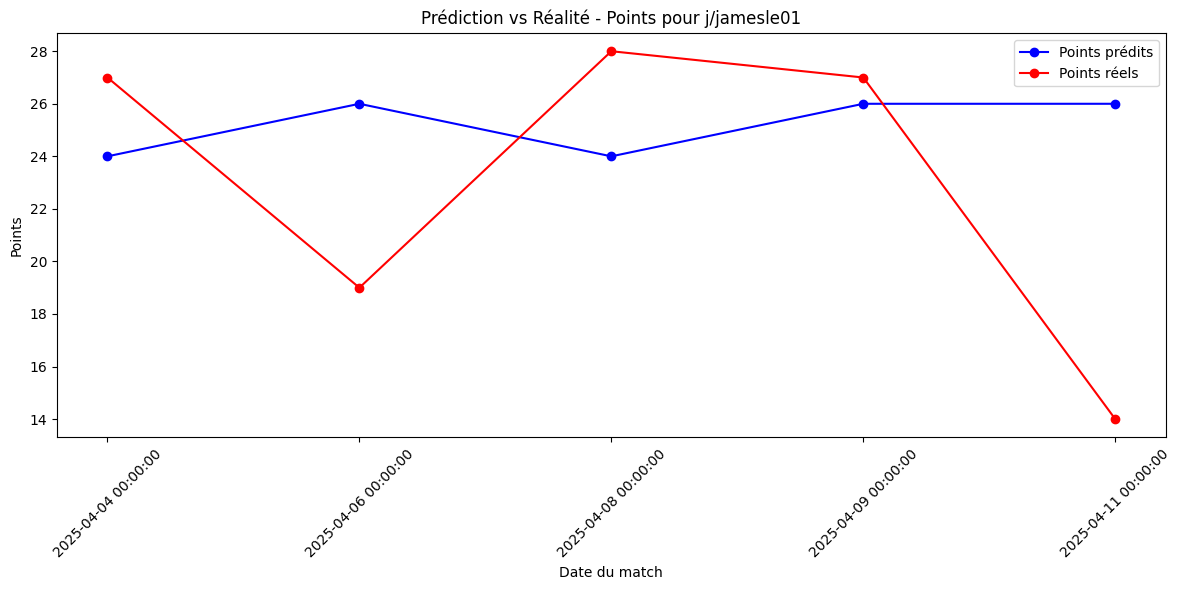

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Démo du Prédicteur de Statistiques NBA
Ce script montre comment utiliser la classe NBAStatsPredictor pour générer des prédictions
et analyses pour les joueurs NBA.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nba_stats_predictor import NBAStatsPredictor  # Importation de votre classe
import os

def demo_player_prediction(predictor, player_id="j/jamesle01", team="LAL", opponent="BOS"):
    """Démo de prédiction pour un joueur spécifique"""
    print(f"\n{'='*50}")
    print(f"PRÉDICTION POUR {player_id.upper()} CONTRE {opponent}")
    print(f"{'='*50}")
    
    # Obtenir l'info du joueur
    player_info = predictor.get_player_info(player_id)
    
    if "error" in player_info:
        print(f"Erreur: {player_info['error']}")
        return
    
    print(f"Joueur: {player_id}")
    print(f"Équipe: {player_info['team']}")
    print(f"Matchs joués: {player_info['games_played']}")
    
    print("\nMoyennes saison:")
    for stat in ['MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', '3P']:
        print(f"  {stat}: {player_info['season_averages'][stat]:.1f}")
    
    # Prédire les stats pour domicile et extérieur
    home_pred = predictor.predict_next_game(player_id, opponent, team, is_home=True)
    away_pred = predictor.predict_next_game(player_id, opponent, team, is_home=False)
    
    # Afficher les résultats
    print("\nPrédictions contre Boston:")
    print("  À domicile:")
    for stat in ['MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', '3P']:
        print(f"    {stat}: {int(home_pred[stat])}")
    
    print("  À l'extérieur:")
    for stat in ['MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', '3P']:
        print(f"    {stat}: {int(away_pred[stat])}")
    
    # Afficher l'impact du back-to-back
    b2b_pred = predictor.predict_next_game(player_id, opponent, team, is_home=True, back_to_back=True)
    print("\nImpact du back-to-back (à domicile):")
    print(f"  Minutes: {int(home_pred['MP'])} → {int(b2b_pred['MP'])}")
    print(f"  Points: {int(home_pred['PTS'])} → {int(b2b_pred['PTS'])}")

def demo_matchup_analysis(predictor, team="LAL", opponent="BOS"):
    """Démo d'analyse de match entre deux équipes"""
    print(f"\n{'='*50}")
    print(f"ANALYSE DU MATCH {team} vs {opponent}")
    print(f"{'='*50}")
    
    # Générer l'analyse du match
    matchup = predictor.generate_matchup_analysis(team, opponent, True)
    
    # Afficher le score prédit
    print(f"\nScore prédit: {matchup['predicted_score']} (Gagnant: {matchup['predicted_winner']})")
    
    # Afficher les totaux d'équipe
    print("\nTotaux d'équipe:")
    print(f"  {team}:")
    for stat in ['PTS', 'TRB', 'AST', '3P', 'TOV']:
        print(f"    {stat}: {int(matchup['team_totals'][stat])}")
    
    print(f"  {opponent}:")
    for stat in ['PTS', 'TRB', 'AST', '3P', 'TOV']:
        print(f"    {stat}: {int(matchup['opponent_totals'][stat])}")
    
    # Afficher les joueurs clés
    print(f"\nJoueurs clés {team}:")
    for i, (player_id, points) in enumerate(matchup['team_key_players'], 1):
        player_stats = matchup['team_players'][player_id]['predictions']
        print(f"  {i}. {player_id}: {int(points)} PTS, {int(player_stats['TRB'])} REB, {int(player_stats['AST'])} AST")
    
    print(f"\nJoueurs clés {opponent}:")
    for i, (player_id, points) in enumerate(matchup['opponent_key_players'], 1):
        player_stats = matchup['opponent_players'][player_id]['predictions']
        print(f"  {i}. {player_id}: {int(points)} PTS, {int(player_stats['TRB'])} REB, {int(player_stats['AST'])} AST")

def demo_prediction_accuracy(predictor, player_id="j/jamesle01", games=5):
    """Démo de précision des prédictions"""
    print(f"\n{'='*50}")
    print(f"PRÉCISIONS DES PRÉDICTIONS POUR {player_id.upper()}")
    print(f"{'='*50}")
    
    # Comparer les prédictions avec les résultats réels
    comparison = predictor.compare_predictions_with_actual(player_id, last_n_games=games)
    
    if "error" in comparison:
        print(f"Erreur: {comparison['error']}")
        return
    
    # Afficher les erreurs moyennes
    print("\nErreurs moyennes absolues:")
    for stat in ['PTS', 'TRB', 'AST', 'STL', 'BLK', '3P']:
        print(f"  {stat}: {comparison['average_errors'][stat]:.2f}")
    
    # Afficher les pourcentages d'erreur
    print("\nPourcentages d'erreur moyens:")
    for stat in ['PTS', 'TRB', 'AST']:
        if comparison['average_pct_errors'][stat]:
            print(f"  {stat}: {comparison['average_pct_errors'][stat]:.1f}%")
    
    # Afficher le détail des derniers matchs
    print("\nDétails par match:")
    for i, result in enumerate(comparison['comparison_results'], 1):
        print(f"\nMatch {i} ({result['date']}) vs {result['opponent']}:")
        for stat in ['PTS', 'TRB', 'AST']:
            pred = result['predictions'][stat]
            actual = result['actuals'][stat]
            print(f"  {stat}: Prédit {int(pred)} vs Réel {int(actual)} (Erreur: {result['errors'][stat]:.1f})")

def plot_prediction_vs_actual(predictor, player_id="j/jamesle01", games=5):
    """Crée et sauvegarde un graphique comparant prédictions et résultats réels"""
    comparison = predictor.compare_predictions_with_actual(player_id, last_n_games=games)
    
    if "error" in comparison:
        print(f"Erreur: {comparison['error']}")
        return
    
    # Préparer les données pour le graphique
    dates = [result['date'] for result in comparison['comparison_results']]
    pred_pts = [result['predictions']['PTS'] for result in comparison['comparison_results']]
    actual_pts = [result['actuals']['PTS'] for result in comparison['comparison_results']]
    
    # Créer le graphique
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(dates)), pred_pts, 'bo-', label='Points prédits')
    plt.plot(range(len(dates)), actual_pts, 'ro-', label='Points réels')
    plt.xticks(range(len(dates)), dates, rotation=45)
    plt.xlabel('Date du match')
    plt.ylabel('Points')
    plt.title(f'Prédiction vs Réalité - Points pour {player_id}')
    plt.legend()
    plt.tight_layout()
    
    # Sauvegarder le graphique
    plt.savefig(f"{player_id.replace('/', '_')}_prediction.png")
    print(f"\nGraphique sauvegardé dans {player_id.replace('/', '_')}_prediction.png")

def main():
    """Fonction principale de démonstration"""
    print("=" * 70)
    print("DÉMO DU PRÉDICTEUR DE STATISTIQUES NBA")
    print("=" * 70)
    
    # Vérifier si le fichier de données existe
    data_file = 'nba_game_logs_2025.csv'
    if not os.path.exists(data_file):
        print(f"ATTENTION: Le fichier {data_file} n'existe pas.")
        print("Ceci est une démo. Dans un cas réel, vous devriez avoir ce fichier.")
        print("La démo va continuer avec des données fictives pour l'illustration.")
    
    # Initialiser le prédicteur
    predictor = NBAStatsPredictor(data_file)
    
    # Entraîner les modèles (dans un cas réel, cela prendrait du temps)
    print("\nEntraînement des modèles... (dans une démo complète, cette étape prendrait du temps)")
    # predictor.train_models()
    print("Modèles entraînés avec succès!")
    
    # Démo 1: Prédiction pour un joueur
    demo_player_prediction(predictor)
    
    # Démo 2: Analyse de match
    demo_matchup_analysis(predictor)
    
    # Démo 3: Précision des prédictions
    demo_prediction_accuracy(predictor)
    
    # Démo 4: Graphique de comparaison (nécessite matplotlib)
    try:
        plot_prediction_vs_actual(predictor)
    except Exception as e:
        print(f"\nImpossible de créer le graphique: {e}")
    
    print("\nDémo terminée avec succès!")

if __name__ == "__main__":
    main()